# Brain Tumor Segmentation using UNET architecture
This project uses U-Net Architecture to create segmentation masks for brain tumor MRI images.

#### Dataset Used:
The dataset used was obtained from kaggle and contains 3064 T1-weighted contrast-enhanced MR images with three kinds of brain tumor. 

#### Data Augmentation:
The basic forms of data augmentation are used here to diversify the training data. All the augmentation methods are used from Pytorch's Torchvision module.

- Horizontally Flip
- Vertically Flip
- Rotation Between 15° to 75°

#### Model Training
Kaggle GPU kernel was used for training purposes:
- `Epochs` -> 100
- `Computation Details` -> Device Used: (cuda), Tesla P100-PCIE-16GB
- `Packages Used Versions` -> Pytorch Version: 1.9.1

#### Results
Mean Dice Score obtained is: 0.720. 

## Import Packages

In [1]:
!pip install torchsummary

In [2]:
from PIL import Image
import os
import numpy as np
%matplotlib inline
import random
import warnings
import pickle
warnings.filterwarnings('ignore')
from tensorboardX import SummaryWriter

from datetime import datetime
from time import time

import torch
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from skimage import data, io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## Custom Dataset Loader

In [3]:
class TumorDataset(Dataset):
    """ Returns a TumorDataset class object which represents our tumor dataset.
    TumorDataset inherits from torch.utils.data.Dataset class.
    """

    def __init__(self, root_dir, transform=True, DEBUG=False):
        self.root_dir = root_dir
        self.transform = {'hflip': TF.hflip,
                          'vflip': TF.vflip,
                          'rotate': TF.rotate}
        self.default_transformation = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((512, 512))
        ])
        self.DEBUG = DEBUG
        if not transform:
            self.transform = None

    def __getitem__(self, index):
        """ Overridden method from inheritted class to support
        indexing of dataset such that datset[I] can be used
        to get Ith sample."""
        image_name = os.path.join(self.root_dir, str(index)+'.png')
        mask_name = os.path.join(self.root_dir, str(index)+'_mask.png')

        image = Image.open(image_name)
        mask = Image.open(mask_name)

        image = self.default_transformation(image)
        mask = self.default_transformation(mask)

        # Custom transformations
        if self.transform:
            image, mask = self._random_transform(image, mask)

        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)

        sample = {'index': int(index), 'image': image, 'mask': mask}
        return sample

    def _random_transform(self, image, mask):
        """ Applies a set of transformation in random order.
        Each transformation has a probability of 0.5
        """
        choice_list = list(self.transform)
        for _ in range(len(choice_list)):
            choice_key = random.choice(choice_list)
            if self.DEBUG:
                print(f'Transform choose: {choice_key}')
            action_prob = random.randint(0, 1)
            if action_prob >= 0.5:
                if self.DEBUG:
                    print(f'\tApplying transformation: {choice_key}')
                if choice_key == 'rotate':
                    rotation = random.randint(15, 75)
                    if self.DEBUG:
                        print(f'\t\tRotation by: {rotation}')
                    image = self.transform[choice_key](image, rotation)
                    mask = self.transform[choice_key](mask, rotation)
                else:
                    image = self.transform[choice_key](image)
                    mask = self.transform[choice_key](mask)
            choice_list.remove(choice_key)

        return image, mask

    def __len__(self):
        """ Overridden method from inheritted class so that
        len(self) returns the size of the dataset.
        """
        error_msg = 'Part of dataset is missing!\nNumber of tumor and mask images are not same.'
        total_files = len(os.listdir(self.root_dir))

        assert (total_files % 2 == 0), error_msg
        return total_files//2

## Brain Tumor Segmentation Model

In [4]:
class BrainTumorClassifier():
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.criterion = BCEDiceLoss(self.device).to(device)
        self.log_path = datetime.now().strftime("%I-%M-%S_%p_on_%B_%d,_%Y")

    def train(self, epochs, trainloader, mini_batch=None, learning_rate=0.001, save_best=None, plot_image=None):
        # Tensorboard Writter
        self.tb_writer = SummaryWriter(log_dir=f'logs/{self.log_path}')
        # Training session history data.
        history = {'train_loss': list()}
        # For save best feature. Initial loss taken a very high value.
        last_loss = 1000
        # Optimizer used for training process. Adam Optimizer.
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # Reducing LR on plateau feature to improve training.
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, factor=0.85, patience=2, verbose=True)
        print('Starting Training Process')
        # Epoch Loop
        for epoch in range(epochs):
            start_time = time()
            # Training a single epoch
            epoch_loss = self._train_epoch(trainloader, mini_batch)
            # Collecting all epoch loss values for future visualization.
            history['train_loss'].append(epoch_loss)
            # Logging to Tensorboard
            self.tb_writer.add_scalar('Train Loss', epoch_loss, epoch)
            self.tb_writer.add_scalar(
                'Learning Rate', self.optimizer.param_groups[0]['lr'], epoch)
            # Reduce LR On Plateau
            self.scheduler.step(epoch_loss)

            # Plotting some sample output on TensorBoard for visualization purpose.
            if plot_image:
                self.model.eval()
                self._plot_image(epoch, plot_image)
                self.model.train()

            time_taken = time()-start_time
            # Training Logs printed.
            print(f'Epoch: {epoch+1:03d},  ', end='')
            print(f'Loss:{epoch_loss:.7f},  ', end='')
            print(f'Time:{time_taken:.2f}secs', end='')

            # Save the best model with lowest epoch loss feature.
            if save_best != None and last_loss > epoch_loss:
                self.save_model(save_best)
                last_loss = epoch_loss
                print(f'\tSaved at loss: {epoch_loss:.10f}')
            else:
                print()
        return history

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def restore_model(self, path):
        if self.device == 'cpu':
            self.model.load_state_dict(torch.load(path, map_location=device))
        else:
            self.model.load_state_dict(torch.load(path))
            self.model.to(self.device)

    def test(self, testloader, threshold=0.5):
        # Putting the model to evaluation mode
        self.model.eval()
        # Getting test data indices for dataloading
        test_data_indexes = testloader.sampler.indices[:]
        # Total testing data used.
        data_len = len(test_data_indexes)
        # Score after testing on dataset.
        mean_val_score = 0

        # Error checking to set testloader batch size to 1.
        batch_size = testloader.batch_size
        if batch_size != 1:
            raise Exception("Set batch size to 1 for testing purpose")
        # Converting to iterator to get data in loops.
        testloader = iter(testloader)
        # Running the loop until no more data is left to test.
        while len(test_data_indexes) != 0:
            # Getting a data sample.
            data = testloader.next()
            # Getting the data index
            index = int(data['index'])
            # Removing the data index from total data indices
            # to indicate this data score has been included.
            if index in test_data_indexes:
                test_data_indexes.remove(index)
            else:
                continue
            # Data prepared to be given as input to model.
            image = data['image'].view((1, 1, 512, 512)).to(self.device)
            mask = data['mask']

            # Predicted output from the input sample.
            mask_pred = self.model(image).cpu()
            # Threshold elimination.
            mask_pred = (mask_pred > threshold)
            mask_pred = mask_pred.numpy()
            
            mask = np.resize(mask, (1, 512, 512))
            mask_pred = np.resize(mask_pred, (1, 512, 512))
            
            # Calculating the dice score for original and 
            # constructed image mask.
            mean_val_score += self._dice_coefficient(mask_pred, mask)

        # Calculating the mean score for the whole test dataset.
        mean_val_score = mean_val_score / data_len
        # Putting the model back to training mode.
        self.model.train()
        return mean_val_score

    def predict(self, data, threshold=0.5):
        self.model.eval()
        image = data['image'].numpy()
        mask = data['mask'].numpy()

        image_tensor = torch.Tensor(data['image'])
        image_tensor = image_tensor.view((-1, 1, 512, 512)).to(self.device)
        output = self.model(image_tensor).detach().cpu()
        output = (output > threshold)
        output = output.numpy()

        image = np.resize(image, (512, 512))
        mask = np.resize(mask, (512, 512))
        output = np.resize(output, (512, 512))
        score = self._dice_coefficient(output, mask)
        return image, mask, output, score

    def _train_epoch(self, trainloader, mini_batch):
        epoch_loss, batch_loss, batch_iteration = 0, 0, 0
        for batch, data in enumerate(trainloader):
            # Keeping track how many iteration is happening.
            batch_iteration += 1
            # Loading data to device used.
            image = data['image'].to(self.device)
            mask = data['mask'].to(self.device)
            # Clearing gradients of optimizer.
            self.optimizer.zero_grad()
            # Calculation predicted output using forward pass.
            output = self.model(image)
            # Calculating the loss value.
            loss_value = self.criterion(output, mask)
            # Computing the gradients.
            loss_value.backward()
            # Optimizing the network parameters.
            self.optimizer.step()
            # Updating the running training loss
            epoch_loss += loss_value.item()
            batch_loss += loss_value.item()

            # Printing batch logs if any.
            if mini_batch:
                if (batch+1) % mini_batch == 0:
                    batch_loss = batch_loss / \
                        (mini_batch*trainloader.batch_size)
                    print(
                        f'    Batch: {batch+1:02d},\tBatch Loss: {batch_loss:.7f}')
                    batch_loss = 0

        epoch_loss = epoch_loss/(batch_iteration*trainloader.batch_size)
        return epoch_loss

    def _plot_image(self, epoch, sample):
        inputs = list()
        mask = list()

        # Inputs seperated.
        for data in sample:
            inputs.append(data['image'])
        # Inputs stacked together in a single batch
        inputs = torch.stack(inputs).to(self.device)
        # Outputs gained from model after passing input.
        outputs = self.model(inputs).detach().cpu()
        # Adding the outputs to Tensorboard for visualization.
        for index in range(len(sample)):
            self.tb_writer.add_image(
                str(sample[index]['index']), outputs[index], epoch)
        # Deleting the samples from GPU memory to save space.
        del inputs

    def _dice_coefficient(self, predicted, target):
        smooth = 1
        product = np.multiply(predicted, target)
        intersection = np.sum(product)
        coefficient = (2*intersection + smooth) / \
            (np.sum(predicted) + np.sum(target) + smooth)
        return coefficient

## Loss Function

In [5]:
class DiceLoss(nn.Module):
    def __init__(self):
        """Simple constructor for the class."""
        super(DiceLoss, self).__init__()

    def forward(self, predicted, target):
        batch = predicted.size()[0]
        batch_loss = 0
        for index in range(batch):
            coefficient = self._dice_coefficient(
                predicted[index], target[index])
            batch_loss += coefficient

        batch_loss = batch_loss / batch

        return 1 - batch_loss

    def _dice_coefficient(self, predicted, target):
        smooth = 1
        product = torch.mul(predicted, target)
        intersection = product.sum()
        coefficient = (2*intersection + smooth) / \
            (predicted.sum() + target.sum() + smooth)
        return coefficient


class BCEDiceLoss(nn.Module):
    def __init__(self, device):
        """Simple constructor for the class."""
        super(BCEDiceLoss, self).__init__()
        self.dice_loss = DiceLoss().to(device)

    def forward(self, predicted, target):
        """ Method for calculation of combined loss from sample."""
        return F.binary_cross_entropy(predicted, target) \
            + self.dice_loss(predicted, target)

## U-Net Architecture for Segmentation

In [6]:
class DynamicUNet(nn.Module):
    def __init__(self, filters, input_channels=1, output_channels=1):
        super(DynamicUNet, self).__init__()

        if len(filters) != 5:
            raise Exception(f"Filter list size {len(filters)}, expected 5!")

        padding = 1
        ks = 3
        # Encoding Part of Network.
        #   Block 1
        self.conv1_1 = nn.Conv2d(input_channels, filters[0], kernel_size=ks, padding=padding)
        self.conv1_2 = nn.Conv2d(filters[0], filters[0], kernel_size=ks, padding=padding)
        self.maxpool1 = nn.MaxPool2d(2)
        #   Block 2
        self.conv2_1 = nn.Conv2d(filters[0], filters[1], kernel_size=ks, padding=padding)
        self.conv2_2 = nn.Conv2d(filters[1], filters[1], kernel_size=ks, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        #   Block 3
        self.conv3_1 = nn.Conv2d(filters[1], filters[2], kernel_size=ks, padding=padding)
        self.conv3_2 = nn.Conv2d(filters[2], filters[2], kernel_size=ks, padding=padding)
        self.maxpool3 = nn.MaxPool2d(2)
        #   Block 4
        self.conv4_1 = nn.Conv2d(filters[2], filters[3], kernel_size=ks, padding=padding)
        self.conv4_2 = nn.Conv2d(filters[3], filters[3], kernel_size=ks, padding=padding)
        self.maxpool4 = nn.MaxPool2d(2)
        
        # Bottleneck Part of Network.
        self.conv5_1 = nn.Conv2d(filters[3], filters[4], kernel_size=ks, padding=padding)
        self.conv5_2 = nn.Conv2d(filters[4], filters[4], kernel_size=ks, padding=padding)
        self.conv5_t = nn.ConvTranspose2d(filters[4], filters[3], 2, stride=2)

        # Decoding Part of Network.
        #   Block 4
        self.conv6_1 = nn.Conv2d(filters[4], filters[3], kernel_size=ks, padding=padding)
        self.conv6_2 = nn.Conv2d(filters[3], filters[3], kernel_size=ks, padding=padding)
        self.conv6_t = nn.ConvTranspose2d(filters[3], filters[2], 2, stride=2)
        #   Block 3
        self.conv7_1 = nn.Conv2d(filters[3], filters[2], kernel_size=ks, padding=padding)
        self.conv7_2 = nn.Conv2d(filters[2], filters[2], kernel_size=ks, padding=padding)
        self.conv7_t = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        #   Block 2
        self.conv8_1 = nn.Conv2d(filters[2], filters[1], kernel_size=ks, padding=padding)
        self.conv8_2 = nn.Conv2d(filters[1], filters[1], kernel_size=ks, padding=padding)
        self.conv8_t = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        #   Block 1
        self.conv9_1 = nn.Conv2d(filters[1], filters[0], kernel_size=ks, padding=padding)
        self.conv9_2 = nn.Conv2d(filters[0], filters[0], kernel_size=ks, padding=padding)

        # Output Part of Network.
        self.conv10 = nn.Conv2d(filters[0], output_channels, kernel_size=ks, padding=padding)

    def forward(self, x):

        # Encoding Part of Network.
        #   Block 1
        conv1 = F.relu(self.conv1_1(x))
        conv1 = F.relu(self.conv1_2(conv1))
        pool1 = self.maxpool1(conv1)
        #   Block 2
        conv2 = F.relu(self.conv2_1(pool1))
        conv2 = F.relu(self.conv2_2(conv2))
        pool2 = self.maxpool2(conv2)
        #   Block 3
        conv3 = F.relu(self.conv3_1(pool2))
        conv3 = F.relu(self.conv3_2(conv3))
        pool3 = self.maxpool3(conv3)
        #   Block 4
        conv4 = F.relu(self.conv4_1(pool3))
        conv4 = F.relu(self.conv4_2(conv4))
        pool4 = self.maxpool4(conv4)

        # Bottleneck Part of Network.
        conv5 = F.relu(self.conv5_1(pool4))
        conv5 = F.relu(self.conv5_2(conv5))

        # Decoding Part of Network.
        #   Block 4
        up6 = torch.cat((self.conv5_t(conv5), conv4), dim=1)
        conv6 = F.relu(self.conv6_1(up6))
        conv6 = F.relu(self.conv6_2(conv6))
        #   Block 3
        up7 = torch.cat((self.conv6_t(conv6), conv3), dim=1)
        conv7 = F.relu(self.conv7_1(up7))
        conv7 = F.relu(self.conv7_2(conv7))
        #   Block 2
        up8 = torch.cat((self.conv7_t(conv7), conv2), dim=1)
        conv8 = F.relu(self.conv8_1(up8))
        conv8 = F.relu(self.conv8_2(conv8))
        #   Block 1
        up9 = torch.cat((self.conv8_t(conv8), conv1), dim=1)
        conv9 = F.relu(self.conv9_1(up9))
        conv9 = F.relu(self.conv9_2(conv9))

        # Output Part of Network.
        output = F.sigmoid(self.conv10(conv9))

        return output

    def summary(self, input_size=(1, 512, 512), batch_size=-1, device='cuda'):
        return summary(self, input_size, batch_size, device)

## Display Results

In [7]:
def result(image, mask, output, title, transparency=0.38, save_path=None):
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(
        20, 15), gridspec_kw={'wspace': 0.025, 'hspace': 0.010})
    fig.suptitle(title, x=0.5, y=0.92, fontsize=20)

    axs[0][0].set_title("Original Mask", fontdict={'fontsize': 16})
    axs[0][0].imshow(mask, cmap='gray')
    axs[0][0].set_axis_off()

    axs[0][1].set_title("Constructed Mask", fontdict={'fontsize': 16})
    axs[0][1].imshow(output, cmap='gray')
    axs[0][1].set_axis_off()

    mask_diff = np.abs(np.subtract(mask, output))
    axs[0][2].set_title("Mask Difference", fontdict={'fontsize': 16})
    axs[0][2].imshow(mask_diff, cmap='gray')
    axs[0][2].set_axis_off()

    seg_output = mask*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][0].set_title("Original Segment", fontdict={'fontsize': 16})
    axs[1][0].imshow(seg_image, cmap='gray')
    axs[1][0].set_axis_off()

    seg_output = output*transparency
    seg_image = np.add(image, seg_output)/2
    axs[1][1].set_title("Constructed Segment", fontdict={'fontsize': 16})
    axs[1][1].imshow(seg_image, cmap='gray')
    axs[1][1].set_axis_off()

    axs[1][2].set_title("Original Image", fontdict={'fontsize': 16})
    axs[1][2].imshow(image, cmap='gray')
    axs[1][2].set_axis_off()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=90, bbox_inches='tight')

    plt.show()


def loss_graph(loss_list, save_plot=None):
    """ Plots the loss graph from the training history data.
    Saves it if required
    """
    plt.figure(figsize=(20, 10))
    plt.title('Loss Function Over Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    line = plt.plot(loss_list, marker='o')
    plt.legend((line), ('Loss Value',), loc=1)
    if save_plot:
        plt.savefig(save_plot)
    plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')

# To Start TensorBoard
# tensorboard --logdir logs --samples_per_plugin images=200

Computation Details
	Device Used: (cuda)  Tesla P100-PCIE-16GB

Packages Used Versions:-
	Pytorch Version: 1.9.1


## Load Dataset

In [9]:
# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASET_USED = 'png_dataset'
# Full Dataset path
DATASET_PATH = os.path.join('./../input/brain-tumor-dataset',DATASET_USED)
# Training Epochs
EPOCHS = 100
# Filters used in UNet Model
FILTER_LIST = [16,32,64,128,256]
# Flag to train the model
TRAIN = True
# Flag to load saved model
LOAD_MODEL = False
# Flag to save model trained
SAVE_MODEL = True
# Model name to save or load.
MODEL_NAME = f"UNet-{FILTER_LIST}.pt"

print(f"Model Name :   {MODEL_NAME}")

Model Name :   UNet-[16, 32, 64, 128, 256].pt


In [10]:
def get_indices(length, new=False):
    """ Gets the Training & Testing data indices for a
    paticular "DATASET_USED".Stores the indices and returns
    them back when the same dataset is used."""
    # Pickle file location of the indices.
    file_path = os.path.join('./',f'split_indices_{DATASET_USED}.p')
    data = dict()
    if os.path.isfile(file_path) and not new:
        # File found.
        with open(file_path,'rb') as file :
            data = pickle.load(file)
            return data['train_indices'], data['test_indices']
    else:
        # File not found or fresh copy is required.
        indices = list(range(length))
        np.random.shuffle(indices)
        split = int(np.floor(TEST_SPLIT * len(tumor_dataset)))
        train_indices , test_indices = indices[split:], indices[:split]
        # Indices are saved with pickle.
        data['train_indices'] = train_indices
        data['test_indices'] = test_indices
        with open(file_path,'wb') as file:
            pickle.dump(data,file)
    return train_indices, test_indices

In [11]:
tumor_dataset = TumorDataset(DATASET_PATH)

train_indices, test_indices = get_indices(len(tumor_dataset))
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(tumor_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(tumor_dataset, 1, sampler=test_sampler)

## Model Training

In [12]:
unet_model = None
unet_classifier = None
if not LOAD_MODEL:
    # New model is created.
    unet_model = DynamicUNet(FILTER_LIST).to(device)
    unet_classifier = BrainTumorClassifier(unet_model,device)
else:
    # Saved model is loaded on memory.
    unet_model = DynamicUNet(FILTER_LIST)
    unet_classifier = BrainTumorClassifier(unet_model,device)
    unet_classifier.restore_model(os.path.join('saved_models',MODEL_NAME))
    print('Saved model loaded')

In [13]:
# Training process
if TRAIN:
    unet_model.train()
    path = os.path.join('./',MODEL_NAME) if SAVE_MODEL else None
    unet_train_history = unet_classifier.train(EPOCHS,trainloader,mini_batch=100,save_best=path)
    print(f'Training Finished after {EPOCHS} epoches')

# Testing process on test data.
unet_model.eval()
unet_score = unet_classifier.test(testloader)
print(f'\n\nDice Score {unet_score}')
# Dice Score 0.7446110107881675

Starting Training Process
    Batch: 100,	Batch Loss: 0.1839811
    Batch: 200,	Batch Loss: 0.1674136
    Batch: 300,	Batch Loss: 0.1685012
    Batch: 400,	Batch Loss: 0.1646741
Epoch: 001,  Loss:0.1707295,  Time:138.76secs	Saved at loss: 0.1707295111
    Batch: 100,	Batch Loss: 0.1587111
    Batch: 200,	Batch Loss: 0.1555778
    Batch: 300,	Batch Loss: 0.1566545
    Batch: 400,	Batch Loss: 0.1547474
Epoch: 002,  Loss:0.1562385,  Time:116.10secs	Saved at loss: 0.1562384968
    Batch: 100,	Batch Loss: 0.1519162
    Batch: 200,	Batch Loss: 0.1523871
    Batch: 300,	Batch Loss: 0.1488255
    Batch: 400,	Batch Loss: 0.1477308
Epoch: 003,  Loss:0.1501180,  Time:115.98secs	Saved at loss: 0.1501179862
    Batch: 100,	Batch Loss: 0.1484739
    Batch: 200,	Batch Loss: 0.1497641
    Batch: 300,	Batch Loss: 0.1430686
    Batch: 400,	Batch Loss: 0.1373219
Epoch: 004,  Loss:0.1444893,  Time:113.97secs	Saved at loss: 0.1444892649
    Batch: 100,	Batch Loss: 0.1384176
    Batch: 200,	Batch Loss: 0.13

## Results and Inferences

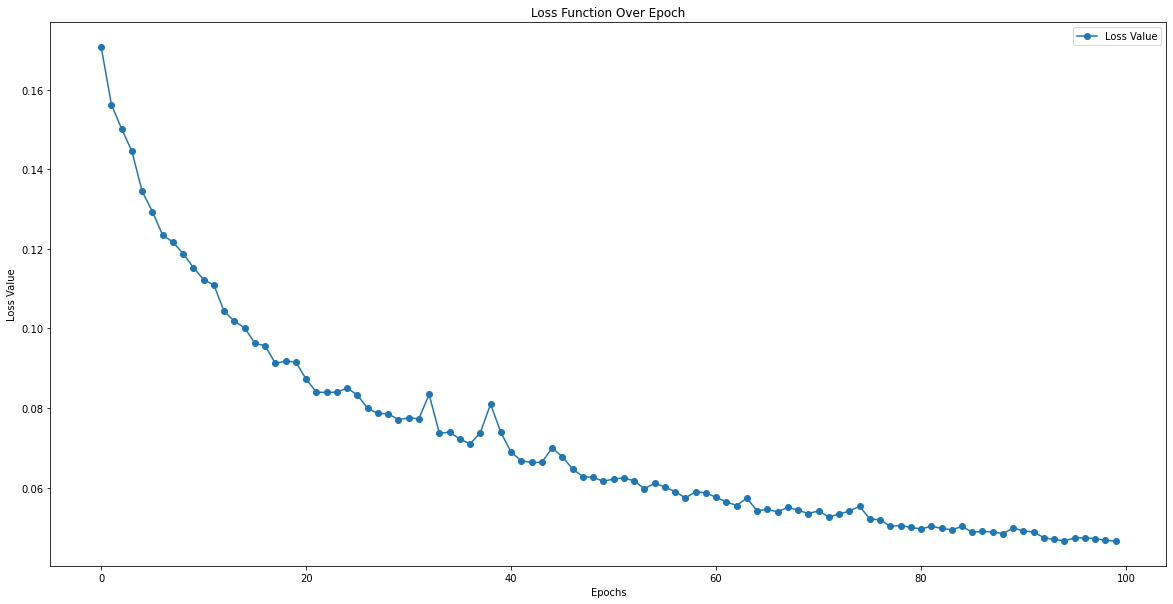

In [14]:
save_plot = os.path.join('./',f'{MODEL_NAME}-loss_graph.png')
loss_graph(unet_train_history['train_loss'],save_plot)

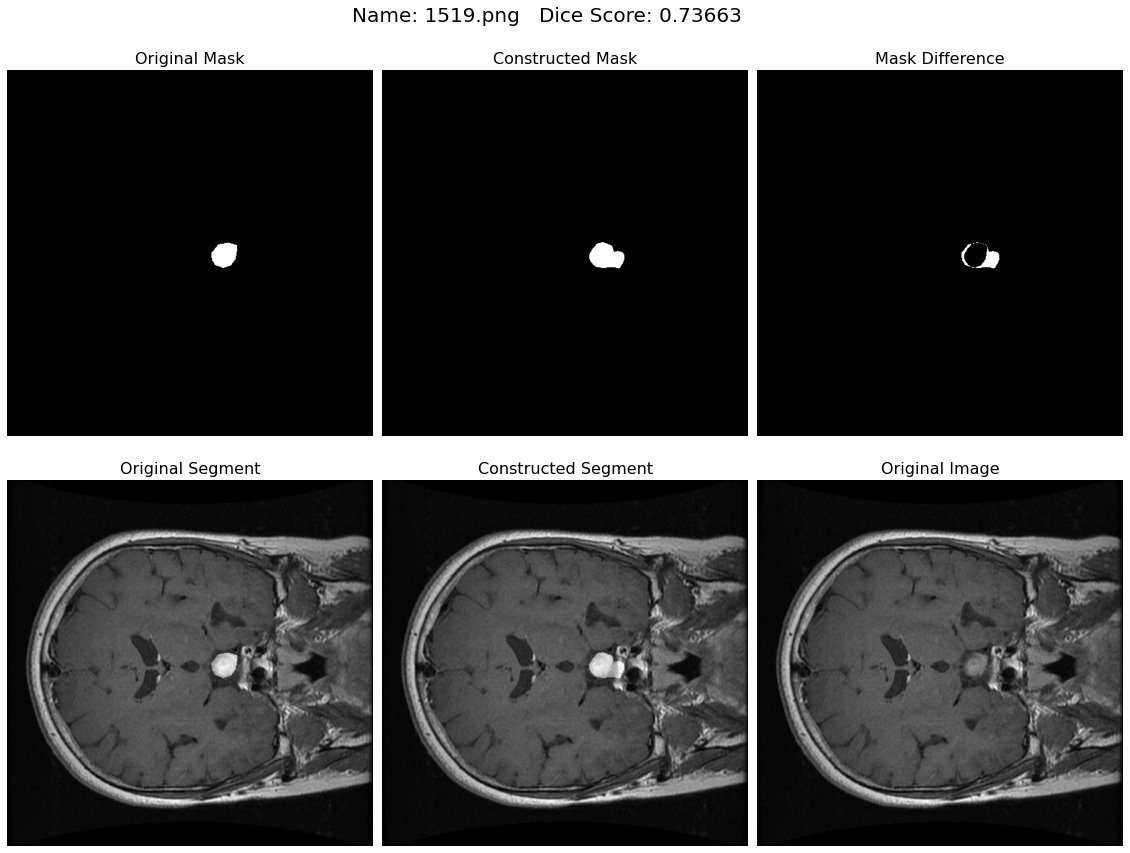

In [15]:
i=0
# Run this cell repeatedly to see some results.
image_index = test_indices[i]
sample = tumor_dataset[image_index]
image, mask, output, d_score = unet_classifier.predict(sample,0.65)
title = f'Name: {image_index}.png   Dice Score: {d_score:.5f}'
# save_path = os.path.join('images',f'{d_score:.5f}_{image_index}.png')
result(image,mask,output,title,save_path=None)
i += 1
if i >= len(test_indices):
    i = 0

## Predictions

In [17]:
# Filters used in U-Net Model
FILTER_LIST = [16,32,64,128,256]
MODEL_NAME = f"inference_file.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Saved model is loaded on memory
unet_model = DynamicUNet(FILTER_LIST)
unet_classifier = BrainTumorClassifier(unet_model,device)
unet_classifier.restore_model(MODEL_NAME)
print('Saved model loaded')

Saved model loaded


In [18]:
# sample
sample = {"image":TF.to_tensor(io.imread('https://i.imgur.com/MWC4ywP.png')),"mask":TF.to_tensor(io.imread('https://i.imgur.com/8g42o7T.png') )}
image, mask, output, d_score = unet_classifier.predict(sample,0.65)

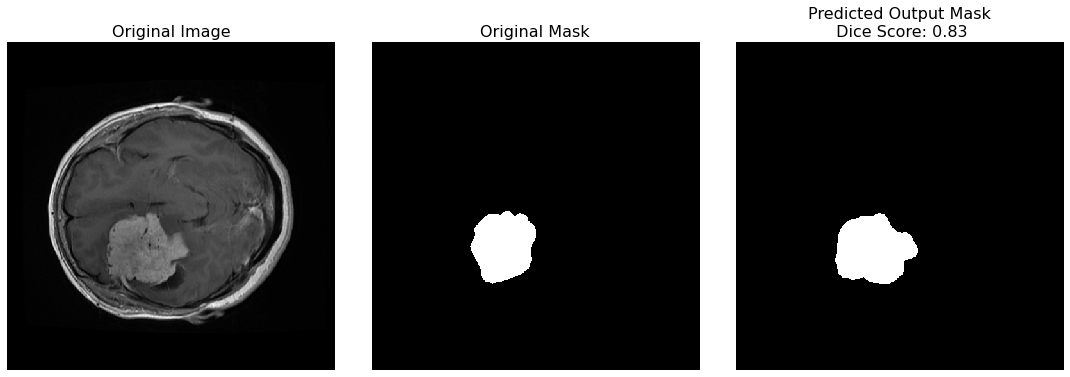

In [21]:
display = [image, mask, output]
titles = ['Original Image' , 'Original Mask' , 'Predicted Output Mask\n Dice Score: {}'.format(round(d_score, 2))]
plt.figure(figsize = (15, 9))

for i in range(len(display)):
    plt.subplot(1, 3, i+1, )
    io.imshow(display[i])
    plt.title(titles[i], fontsize = 16)
    plt.axis(False)